In [22]:
import manganite
%load_ext manganite

# Workforce Scheduling Problem

## Objective and Prerequisites

In this example, you’ll learn how to solve a critical, central problem in the services industry: workforce scheduling. We’ll demonstrate how you can use mathematical optimization to generate an optimal workforce schedule that meets your business requirements, maximizes employee fairness and satisfaction, and minimizes the number of temporary workers your company needs to hire.

This modeling example is at the advanced level, where we assume that you know Python and the Gurobi Python API and that you have advanced knowledge of building mathematical optimization models. Typically, the objective function and/or constraints of these examples are complex or require advanced features of the Gurobi Python API.

**Download the Repository** <br />
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 

**Gurobi License** <br />
In order to run this Jupyter Notebook properly, you must have a Gurobi license. If you do not have one, you can request an [evaluation license](https://www.gurobi.com/downloads/request-an-evaluation-license/?utm_source=3PW&utm_medium=OT&utm_campaign=WW-MU-PRO-OR-O_LEA-PR_NO-Q3_FY20_WW_JPME_workforce-scheduling_COM_EVAL_GITHUB_&utm_term=workforce-scheduling-problem&utm_content=C_JPM) as a *commercial user*, or download a [free license](https://www.gurobi.com/academia/academic-program-and-licenses/?utm_source=3PW&utm_medium=OT&utm_campaign=WW-MU-PRO-OR-O_LEA-PR_NO-Q3_FY20_WW_JPME_workforce-scheduling_ACADEMIC_EVAL_GITHUB_&utm_term=workforce-scheduling-problem&utm_content=C_JPM) as an *academic user*.

## Motivation
People are the most important asset for companies in the services industry as well as their largest source of costs.
Workforce allocation and personnel scheduling deal with the arrangement of work schedules  and the assignment of personnel shifts in order to cover the demand for resources that vary over time.

These problems are very important for companies in the services industries who rely on workforce resources such as:
- Telephone operators
- Hospital nurses
- Policemen
- Transportation personnel (plane crews, bus drivers, etc.)
- Hospitality personnel
- Restaurant personnel

## Problem Description

Consider a service business, like a restaurant, that develops its workforce plans for the next two weeks (considering a 7-day week). The service requires only one set of skills. There are a number of employed workers with the same set of skills and with identical productivity that are available to work on some of the days during the two-week planning horizon. There is only one shift per workday. Each shift may have different resource (worker) requirements on each workday. The service business may hire extra (temp) workers from an agency to satisfy shift requirements. The service business wants to minimize the number of extra workers that it needs to hire, and as a secondary objective, it wants to balance the workload of employed workers to ensure fairness.

In [23]:
# This command imports the Gurobi functions and classes.

import gurobipy as gp
from gurobipy import GRB


import pandas as pd
from pylab import *
import matplotlib
import matplotlib.pyplot as plt

## Input Data

We define all the input data of the model.

### Parameter

$\text{shiftRequirements}(s) \in \mathbb{N}$: This parameter represents the number of workers required at each shift 
$s \in \text{shifts}$.

In [41]:
%%mnn widget --type table --tab "Input"  --header "Number of workers required for each shift" --var df_shift

df_shift = pd.DataFrame({ "Day": [ "Mon1", "Tue2", "Wed3", "Thu4", "Fri5", "Sat6", "Sun7", "Mon8", "Tue9","Wed10","Thu11","Fri12","Sat13","Sun14"],
"Requirement" : [3,2,4,4,5,6,5,2,2,3,4,6,7,5]})
# Number of workers required for each shift.
shifts, shiftRequirements = gp.multidict(dict(zip(df_shift['Day'].to_list(),df_shift['Requirement'].to_list())))
# shifts, shiftRequirements = gp.multidict({
#   "Mon1":  3,
#   "Tue2":  2,
#   "Wed3":  4,
#   "Thu4":  4,
#   "Fri5":  5,
#   "Sat6":  6,
#   "Sun7":  5,
#   "Mon8":  2,
#   "Tue9":  2,
#   "Wed10": 3,
#   "Thu11": 4,
#   "Fri12": 6,
#   "Sat13": 7,
#   "Sun14": 5 })

### Parameter

$pay(w) \in \mathbb{R^{+}}$: This parameter is the salary per day of each worker $w \in workers$. 

In [34]:
%%mnn widget --type table --tab "Input" --position 0 0 3 --header "Each workers wage to work one shift" --var df_wp
df_wp = pd.DataFrame({"Workers": ["Amy","Bob","Cathy","Dan","Ed","Fred","Gu"], "Pay": [10,12,10,8,8,9,11] })
# Amount each worker is paid to work one shift.
workers, pay =  gp.multidict(dict(zip(df_wp['Workers'].to_list(),df_wp['Pay'].to_list())))
# workers, pay = gp.multidict({
#   "Amy":   10,
#   "Bob":   12,
#   "Cathy": 10,
#   "Dan":   8,
#   "Ed":    8,
#   "Fred":  9,
#   "Gu":    11 })

### Set

$availability= \{(w,s): w \in workers \; \text{is available for} \; s \in \text{shifts} \}$: This set determines that the employed worker  $w$ is available to work on shift $s$.



In [46]:
# Worker availability: defines on which day each employed worker is available.
# to be visualised
availability = gp.tuplelist([
('Amy', 'Tue2'), ('Amy', 'Wed3'), ('Amy', 'Fri5'), ('Amy', 'Sun7'),
('Amy', 'Tue9'), ('Amy', 'Wed10'), ('Amy', 'Thu11'), ('Amy', 'Fri12'),
('Amy', 'Sat13'), ('Amy', 'Sun14'), ('Bob', 'Mon1'), ('Bob', 'Tue2'),
('Bob', 'Fri5'), ('Bob', 'Sat6'), ('Bob', 'Mon8'), ('Bob', 'Thu11'),
('Bob', 'Sat13'), ('Cathy', 'Wed3'), ('Cathy', 'Thu4'), ('Cathy', 'Fri5'),
('Cathy', 'Sun7'), ('Cathy', 'Mon8'), ('Cathy', 'Tue9'), ('Cathy', 'Wed10'),
('Cathy', 'Thu11'), ('Cathy', 'Fri12'), ('Cathy', 'Sat13'),
('Cathy', 'Sun14'), ('Dan', 'Tue2'), ('Dan', 'Wed3'), ('Dan', 'Fri5'),
('Dan', 'Sat6'), ('Dan', 'Mon8'), ('Dan', 'Tue9'), ('Dan', 'Wed10'),
('Dan', 'Thu11'), ('Dan', 'Fri12'), ('Dan', 'Sat13'), ('Dan', 'Sun14'),
('Ed', 'Mon1'), ('Ed', 'Tue2'), ('Ed', 'Wed3'), ('Ed', 'Thu4'),
('Ed', 'Fri5'), ('Ed', 'Sun7'), ('Ed', 'Mon8'), ('Ed', 'Tue9'),
('Ed', 'Thu11'), ('Ed', 'Sat13'), ('Ed', 'Sun14'), ('Fred', 'Mon1'),
('Fred', 'Tue2'), ('Fred', 'Wed3'), ('Fred', 'Sat6'), ('Fred', 'Mon8'),
('Fred', 'Tue9'), ('Fred', 'Fri12'), ('Fred', 'Sat13'), ('Fred', 'Sun14'),
('Gu', 'Mon1'), ('Gu', 'Tue2'), ('Gu', 'Wed3'), ('Gu', 'Fri5'),
('Gu', 'Sat6'), ('Gu', 'Sun7'), ('Gu', 'Mon8'), ('Gu', 'Tue9'),
('Gu', 'Wed10'), ('Gu', 'Thu11'), ('Gu', 'Fri12'), ('Gu', 'Sat13'),
('Gu', 'Sun14')
])

## Model Deployment

In [ ]:
%%mnn execute --on button "Optimize Shifts" --returns optimisation_done

# Create initial model.
m = gp.Model("workforce5")

# Initialize assignment decision variables.

x = m.addVars(availability, vtype=GRB.BINARY, name="x")

# Slack decision variables determine the number of extra workers required to satisfy the requirements 
# of each shift
slacks = m.addVars(shifts, name="Slack")
# Auxiliary variable totSlack to represent the total number of extra workers required to satisfy the 
# requirements of all the shifts.
totSlack = m.addVar(name='totSlack')
# Auxiliary variable totShifts counts the total shifts worked by each employed worker
totShifts = m.addVars(workers, name="TotShifts")
# Constraint: All shifts requirements most be satisfied.

shift_reqmts = m.addConstrs((x.sum('*',s) + slacks[s] == shiftRequirements[s] for s in shifts), name='shiftRequirement')
# Constraint: set the auxiliary variable (totSlack) equal to the total number of extra workers 
# required to satisfy shift requirements
 
num_temps = m.addConstr(totSlack == slacks.sum(), name='totSlack')
# Constraint: compute the total number of shifts for each worker

num_shifts = m.addConstrs((totShifts[w] == x.sum(w,'*') for w in workers), name='totShifts')

# Auxiliary variables. 
# minShift is the minimum number of shifts allocated to workers 
# maxShift is the maximum number of shifts allocated to workers

minShift = m.addVar(name='minShift')

maxShift = m.addVar(name='maxShift')

# Constraint: 
# The addGenConstrMin() method of the model object m adds a new general constraint that 
# determines the minimum value among a set of variables. 
# The first argument is the variable whose value will be equal to the minimum of the other variables, 
# minShift in this case. 
# The second argument is the set variables over which the minimum will be taken, (totShifts) in 
# this case. 
# Recall that the totShifts variable is defined over the set of worker and determines the number of 
# shifts that an employed worker will work. The third argument is the name of this constraint.

min_constr = m.addGenConstrMin(minShift, totShifts, name='minShift')

# Constraint: 
# Similarly, the addGenConstrMax() method of the model object m adds a new general 
# constraint that determines the maximum value among a set of variables.

max_constr = m.addGenConstrMax(maxShift, totShifts, name='maxShift')
# Set global sense for ALL objectives.
# This means that all objectives of the model object m are going to be minimized
m.ModelSense = GRB.MINIMIZE
# Set up primary objective.

# The setObjectiveN() method of the model object m allows to define multiple objectives.
# The first argument is the linear expression defining the most important objective, called primary 
# objective, in this case it is the minimization of extra workers required to satisfy shift 
# requirements. 
# The second argument is the index of the objective function, we set the index of the primary 
# objective to be equal to 0. 
# The third argument is the priority of the objective.
# The fourth argument is the relative tolerance to degrade this objective when a lower priority
# objective is optimized. The fifth argument is the name of this objective.
# A hierarchical or lexicographic approach assigns a priority to each objective, and optimizes 
# for the objectives in decreasing priority order. 
# For this problem, we have two objectives, and the primary objective has the highest priority 
# which is equal to 2. 
# When the secondary objective is minimized, since the relative tolerance is 0.2, we can only 
# increase the minimum number of extra workers up to 20%. 
# For example if the minimum number extra workers is 10, then when optimizing the secondary objective 
# we can have up to 12 extra workers.

m.setObjectiveN(totSlack, index=0, priority=2, reltol=0.2, name='TotalSlack')
# Set up secondary objective.

# The secondary objective is called fairness and its goal is to balance the workload assigned 
# to the employed workers. 
# To balance the workload assigned to the employed workers, we can minimize the difference 
# between the maximum number of shifts assigned to an employed worker and the minimum number 
# of shifts assigned to an employed worker.

m.setObjectiveN(maxShift - minShift, index=1, priority=1, name='Fairness')
# Save model formulation for inspection

m.write('workforce.lp')
# Optimize
# This method runs the optimization engine to solve the MIP problem in the model object m
m.optimize()
# The Status attribute  provides current optimization status of the model object m
# In workforce model, we check if the model is infeasible or unbounded and report this situation
status = m.Status
if status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is infeasible or unbounded')
    sys.exit(0)
# If the optimization status of the model is not optimal for some other reason, we report that 
# situation.
if status != GRB.Status.OPTIMAL:
    print('Optimization was stopped with status ' + str(status))
    sys.exit(0)

### Decision Variables

$x(w,s) \in \{0,1\}$: This variable equals 1 if worker $w \in workers$ is assigned to shift $s \in \text{shifts}$, 
and 0 otherwise.
This decision variable is defined over the $availability$ set.

$Slack(s) \geq 0$: This variable is the number of extra workers required to satisfy the requirements of shift $s$.

### Auxiliary Variables
Auxiliary variables are derived from the values of the decision variables.

$totSlack$: This variable counts the total number of extra workers required to satisfy the demand for shift workers.

$\text{totShifts}(w)$: This variable counts the total number of shifts worked by each worker $w \in workers$.

$\text{minShift}$: This variable determines the minimum number of shifts allocated to workers. 

$\text{maxShift}$: This variable  determines the maximum number of shifts allocated to workers.

### Constraint

$$\sum_{w \: \in \: workers} x(w,s) \; + \; Slack(s) \; = \; \text{shiftRequirements}(s) \; \; \; \forall \; s \in shifts $$

### Constraint

$$ \sum_{s \: \in \: shifts} Slack(s) \; = \; totSlack  $$

### Constraint

$$\sum_{s \: \in \: shifts} x(w,s) \; = \; \text{totShifts}(w) \; \; \forall \ w \; in \; workers$$

The variable $\text{minShift}$ determines the minimum numbers of shifts allocated to workers. This variable is calculated as follows:
$\text{minShift} = Min \{\text{totShifts}(w): \ w \; in \; workers \} $

The variable $\text{maxShift}$ determines the maximum numbers of shifts allocated to workers. This variable is calculated as follows:
$\text{maxShift} = Max \{\text{totShifts}(w): \ w \; in \; workers \} $

We have a primary and a secondary objective which both aim to minimize.

## Objective Function

The primary objective is to minimize the total number of extra workers required to satisfy shift requirements. 
$$
\text{Min} \; totSlack \; = \; \sum_{s \: \in \: shifts} Slack(s) 
$$

For this objective we allow a degradation tolerance of up to certain percentage. If reltol = 0.2, then we allow a degradation
tolerance of 20%. 

The secondary objective is to balance workload among workers. To do so, we minimize the difference between the maximum 
number of shifts allocated to a worker, and the minimum number of shifts allocated to a worker. That is
$$
\text{Min} \; (\text{maxShift}  -  \text{minShift}) 
$$ 

                    KPI Value
0  Total slack required   7.0
--------------------------------------------------
Shifts
  Worker  Number of shifts
0    Amy               8.0
1    Bob               7.0
2  Cathy               7.0
3    Dan               7.0
4     Ed               7.0
5   Fred               8.0
6     Gu               7.0


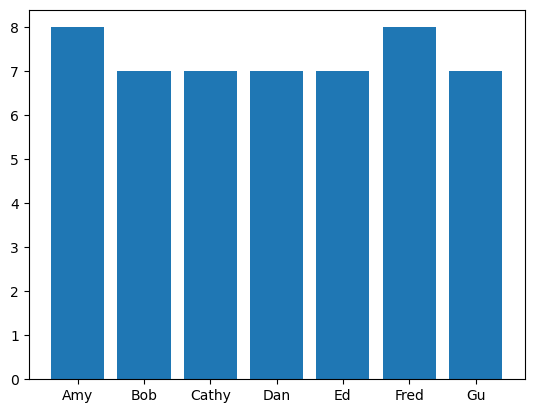

--------------------------------------------------
Assigments
Symbols: '-': not working, '*': working
  worker Mon1 Tue2 Wed3 Thu4 Fri5 Sat6 Sun7 Mon8 Tue9 Wed10 Thu11 Fri12 Sat13 Sun14
0    Amy    -    -    *    -    *    -    *    -    -     *     *     *     *     *
1    Bob    *    *    -    -    *    *    -    *    -     -     *     -     *     -
2  Cathy    -    -    -    *    *    -    *    -    -     *     *     -     *     *
3    Dan    -    *    *    -    *    *    -    -    -     *     -     *     *     -
4     Ed    -    -    *    *    *    -    *    -    -     -     *     -     *     *
5   Fred    *    -    *    -    -    *    -    *    *     -     -     *     *     *
6     Gu    *    -    -    -    -    *    *    -    *     -     -     *     *     *


In [20]:
# # Print total slack and the number of shifts worked for each worker
# # The KPIs for this optimization number is the number of extra worked required to satisfy 
# # demand and the number of shifts that each employed worker is working.
# solution = {}
# shifts_sol = {}
# solution['Total slack required'] = str(totSlack.X)
# assignments_all = {}
# gant={}

# assignments = dict()
# for [w, s] in availability:
#     if x[w, s].x == 1:
#         if w in assignments:
#             assignments[w].append(s)
#         else:
#             assignments[w] = [s]


# print(pd.DataFrame.from_records(list(solution.items()), columns=['KPI', 'Value']))
# print('-'*50)

# for w in workers:
#     shifts_sol[w]=totShifts[w].X
#     assignments_all[w]=assignments.get(w, [])

# print('Shifts')
# print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['Worker', 'Number of shifts']))
    
# y_pos = np.arange(len(shifts_sol.keys())) 
# plt.bar(y_pos,shifts_sol.values() , align='center')
# plt.xticks(y_pos, shifts_sol.keys())
# plt.show()

# print('-'*50)
# for w in assignments_all:
#     gant[w] = [w]
#     for d in shifts:
#         gant[w].append('*' if d in assignments_all[w] else '-')

# print('Assigments')
# print('Symbols: \'-\': not working, \'*\': working')
# pd.set_option('display.width', 1000)
# print(pd.DataFrame.from_records(list(gant.values()), columns=['worker']+shifts))

## Analysis

The total number of extra workers required to satisfy the shift requirements during the planning horizon is seven.

The bar chart shows the number of shifts that each employed worker will work during the planning horizon. Observe that with seven extra workers, the workload of employed workers is quite balanced.

The last table shows which day during the planning horizon each employed worker is working.

## Conclusion

In this Jupyter Notebook, we discussed a workforce scheduling optimization problem that is common in the services industry.
Consider a service business that develops its workforce plans for the next two weeks. There is only one shift per workday. Each shift may have different workers requirements on each workday. The service business may hire extra workers from an agency to satisfy shift requirements. The service business wants to minimize the number of extra workers that needs to hire, and as a secondary objective, it wants to balance the workload of employed workers.

The problem was formulated as a multi-objective mixed-integer-programming (MIP) model,
and implemented using the Gurobi Python API and solved using the Gurobi Optimizer.

The hierarchical  approach to tackling multi-objective function problems was explained in detail.


Copyright © 2020 Gurobi Optimization, LLC